In [1]:
import datetime
import gc
import math
import numpy as np
import open3d as o3
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from fastai.vision import Path
from math import sin, cos, acos, pi
from pprint import pprint

In [2]:
def getCore(data):
    coreTmp = np.zeros((1, 3))
    coreTmp[:, 0] = np.sum(data[:, ::3], axis=1) / (data.shape[1] / 3)   #coreX
    coreTmp[:, 1] = np.sum(data[:, 1::3], axis=1) / (data.shape[1] / 3)  #coreY
    coreTmp[:, 2] = np.sum(data[:, 2::3], axis=1) / (data.shape[1] / 3)  #coreZ

    return coreTmp


def dataShift(data, core):    #使全部點剛好在第一象限
    data[:, ::3] = data[:, ::3] - core[0, 0]
    data[:, 1::3] = data[:, 1::3] - core[0, 1]
    data[:, 2::3] = data[:, 2::3] - core[0, 2]

    xShiftTmp = min(data[0, ::3])
    yShiftTmp = min(data[0, 1::3])
    zShiftTmp = min(data[0, 2::3])

    data[:, ::3] = data[:, ::3] - xShiftTmp
    data[:, 1::3] = data[:, 1::3] - yShiftTmp
    data[:, 2::3] = data[:, 2::3] - zShiftTmp

    return data


def getMaxRadius(data):
    maxTmp = 0
    indexTmp = 0

    for i in range(data.shape[1] // 3):
        tmp = np.sqrt(np.square(data[0, i*3]) + np.square(data[0, i*3 + 1]) + np.square(data[0, i*3 + 2]))
        if (tmp  > maxTmp):
            maxTmp = tmp
            indexTmp = i    

    return indexTmp, maxTmp


def getAABBSize(rdata):  
    xTmp = rdata[0, ::3]
    yTmp = rdata[0, 1::3]
    zTmp = rdata[0, 2::3]

    xDis = max(xTmp) - min(xTmp)
    yDis = max(yTmp) - min(yTmp)
    zDis = max(zTmp) - min(zTmp) 

    return xDis, yDis, zDis


def get3DMatrix(xDis, yDis, zDis, rData):
    MCount = np.zeros((mSize, mSize, mSize))
    MCount = MCount + 1e-7    #避免除零    
    MResult = np.zeros((mSize, mSize, mSize * 3))    #三通道
    MXSum = np.zeros((mSize, mSize, mSize))
    MYSum = np.zeros((mSize, mSize, mSize))
    MZSum = np.zeros((mSize, mSize, mSize))

    for i in range (rData.shape[1] // 3):
        D1Tmp = math.floor(rData[0, i*3] / xDis * mSize)
        D2Tmp = math.floor(rData[0, i*3 + 1] / yDis * mSize)
        D3Tmp = math.floor(rData[0, i*3 + 2] / zDis * mSize)
        
        D1Tmp = np.minimum(12, D1Tmp)
        D2Tmp = np.minimum(12, D2Tmp)
        D3Tmp = np.minimum(12, D3Tmp)
        
        D1Tmp = np.maximum(-12, D1Tmp)
        D2Tmp = np.maximum(-12, D2Tmp)
        D3Tmp = np.maximum(-12, D3Tmp)

        if D1Tmp != mSize and D2Tmp != mSize and D3Tmp != mSize:
            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
        else:
            D1Tmp = D1Tmp - 1 if D1Tmp == mSize else D1Tmp
            D2Tmp = D2Tmp - 1 if D2Tmp == mSize else D2Tmp
            D3Tmp = D3Tmp - 1 if D3Tmp == mSize else D3Tmp

            MCount[D1Tmp, D2Tmp, D3Tmp] = MCount[D1Tmp, D2Tmp, D3Tmp] + 1
            MXSum[D1Tmp, D2Tmp, D3Tmp] = MXSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3]
            MYSum[D1Tmp, D2Tmp, D3Tmp] = MYSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 1]
            MZSum[D1Tmp, D2Tmp, D3Tmp] = MZSum[D1Tmp, D2Tmp, D3Tmp] + rData[0, i*3 + 2]
            
    MXSum = np.divide(MXSum, MCount)
    MYSum = np.divide(MYSum, MCount)
    MZSum = np.divide(MZSum, MCount)

    for i in range(mSize):
        MResult[:, :, i * 3] = MXSum[:, :, i]
        MResult[:, :, i * 3 + 1] = MYSum[:, :, i]
        MResult[:, :, i * 3 + 2] = MZSum[:, :, i]

    return MResult    

def q_norm(q):
    return np.sum(np.square(q))


def q_inv(q):
    invq = np.array([-q[0], -q[1], -q[2], q[3]]) / q_norm(q)
    return invq


def q_mut(q1, q2):
    assert len(q1) == 4 == len(q2)
    a1, b1, c1, d1 = q1
    a2, b2, c2, d2 = q2
    
    qw = (a1 * a2 - b1 * b2 - c1 * c2 - d1 * d2)
    qx = (a1 * b2 + b1 * a2 + c1 * d2 - d1 * c2)
    qy = (a1 * c2 - b1 * d2 + c1 * a2 + d1 * b2)
    qz = (a1 * d2 + b1 * c2 - c1 * b2 + d1 * a2)
    
    return np.array([qw, qx, qy, qz])

def rotate_with_q(xyz, q):
    xyz_tmp = np.append(xyz, 0)
    q_tmp = q_mut(q, q_mut(xyz_tmp, q_inv(q)))
    return q_tmp[:3]

def eva_rms(pred, tar):
    pred_tmp = pred.reshape(-1)
    tar_tmp = tar.reshape(-1)
    assert pred_tmp.shape == tar_tmp.shape

    return np.sqrt(np.mean((pred_tmp - tar_tmp)**2))

def show_pcd_3d(x_data, save=False, name=None):
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(x_data))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = x_data[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')
        ax.set_title(idx)
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_pcd.png')


def show_match_result(pred, tar, save=False, name=None):
    '''
    pcd shape must have dimension of number of pcd, 
    like (num, x, x, x, 3), (num, -1), (num, -1, 3)
    '''
    assert len(pred) == len(tar)
    fig = plt.figure(figsize=(12, 12))
    index = np.arange(len(tar))
    np.random.shuffle(index)
    index = index[:9]
    for i, idx in enumerate(index):
        data = tar[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]

        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
        ax.scatter(x, y, z, c='r', marker='o')

        data = pred[idx].reshape(-1, 3)
        x = data[:, 0]
        y = data[:, 1]
        z = data[:, 2]
        ax.scatter(x, y, z, c='b', marker='o')

        ax.set_title(f'index: {idx}, RMS: {eva_rms(pred[idx], tar[idx]):.2f}')
    if save:
        if not Path('results').exists():
            Path('results').mkdir()
        plt.savefig(f'results/{name}_match_result.png')

def scalar_reduction(x_hat, x_max, x_min):
    reduction = x_hat * (x_max - x_min) + x_min
    return np.float32(reduction)

def get_files_names(path):
    fnames=[]
    for idx, name in enumerate(path.ls()):
        if name.suffix == '.pcd':
            fnames.append(name)
    return fnames



## Load PCD
Downsample Number 
socket =1

In [53]:
load_pcd = o3.read_point_cloud("data/ori/bunny/bunny.ply", "ply")
# down_pcd = o3.voxel_down_sample(load_pcd, voxel_size = 0.002) #
down_pcd = load_pcd

In [54]:
ori_pcd = np.asarray(load_pcd.points)
whole_pcd = np.asarray(down_pcd.points)

In [55]:
test = np.asarray(ori_pcd)
np.savetxt("ori_whole_pcd.txt", ori_pcd)
pcd = o3.read_point_cloud("ori_whole_pcd.txt", format='xyz')
o3.write_point_cloud("ori_whole_pcd.pcd", pcd)
o3.visualization.draw_geometries([pcd])

In [16]:
ori_pcd.shape, whole_pcd.shape

((35947, 3), (35947, 3))

In [17]:
o3.visualization.draw_geometries([load_pcd])

In [18]:
o3.visualization.draw_geometries([down_pcd])

## Shift all points over the plane of z = 0

In [19]:
shift = np.asarray([(np.max(whole_pcd[:,0])+np.min(whole_pcd[:,0]))/2, (np.max(whole_pcd[:,1])+np.min(whole_pcd[:,1]))/2, (np.max(whole_pcd[:,2])+np.min(whole_pcd[:,2]))/2])
whole_pcd -= shift

## Find the max and min of x, y, z

In [20]:
(xMax, yMax, zMax) = (np.max(whole_pcd[:,0]), np.max(whole_pcd[:,1]), np.max(whole_pcd[:,2]))

In [21]:
(xMin, yMin, zMin) = (np.min(whole_pcd[:,0]), np.min(whole_pcd[:,1]), np.min(whole_pcd[:,2]))

In [22]:
xMax, yMax, zMax

(0.07784949999999999, 0.0771668, 0.060336650000000006)

In [23]:
xMin, yMin, zMin

(-0.07784949999999999, -0.0771668, -0.060336650000000006)

## Define Object Center and Vision Center

In [24]:
distance = xMax - xMin

objCenter_x = (xMax + xMin)/2
objCenter_y = (yMax + yMin)/2
objCenter_z = (zMax + zMin)/2
print((objCenter_x, objCenter_y, objCenter_z))

cameraCenter_x = objCenter_x - distance*5
cameraCenter_y = objCenter_y + distance*5
cameraCenter_z = objCenter_z - distance*5
print((cameraCenter_x, cameraCenter_y, cameraCenter_z))

(0.0, 0.0, 0.0)
(-0.7784949999999999, 0.7784949999999999, -0.7784949999999999)


## Change the Perspective

In [25]:
vecView = np.array([cameraCenter_x-objCenter_x, cameraCenter_y-objCenter_y, cameraCenter_z-objCenter_z])

vecView_xy = np.array([vecView[0], vecView[1], 0])
scale = np.linalg.norm(vecView_xy)
vecView_xy /= scale
print(vecView_xy)

vecView_xz = np.array([vecView[0], 0, vecView[2]])
scale = np.linalg.norm(vecView_xz)
vecView_xz /= scale

vecView_yz = np.array([0, vecView[1], vecView[2]])
scale = np.linalg.norm(vecView_yz)
vecView_yz /= scale

[-0.707107  0.707107  0.      ]


In [26]:
e1 = np.array([1, 0, 0])
e2 = np.array([0, 1, 0])
e3 = np.array([0, 0, 1])

gamma = acos(np.dot(vecView_xy, e1))
print("gamma = " + str(gamma*(180/pi)))

beta = -acos(np.dot(vecView_xz, e3))
print("beta  = " + str(beta*(180/pi)))

alpha = -acos(np.dot(vecView_yz, e2))
print("alpha  = " + str(alpha*(180/pi)))

Rot = np.array([[ cos(gamma)*cos(beta), -sin(gamma)*cos(alpha)+cos(gamma)*sin(beta)*sin(alpha),  sin(gamma)*sin(alpha)+cos(gamma)*sin(beta)*cos(alpha)], 
                [ sin(gamma)*cos(beta),  cos(gamma)*cos(alpha)+sin(gamma)*sin(beta)*sin(alpha), -cos(gamma)*sin(alpha)+sin(gamma)*sin(beta)*cos(alpha)], 
                [-sin(beta),             cos(beta)*sin(alpha),                                   cos(beta)*cos(alpha)]])

print(Rot)

gamma = 135.0
beta  = -135.0
alpha  = -45.00000000000001
[[ 0.5      -0.853553 -0.146447]
 [-0.5      -0.146447 -0.853553]
 [ 0.707107  0.5      -0.5     ]]


In [27]:
vecView = np.matmul(Rot, vecView)

for i in range(whole_pcd.shape[0]):
    whole_pcd[i] = np.matmul(Rot, whole_pcd[i])

## Create subcubes

In [28]:
(xMax, yMax, zMax) = (np.max(whole_pcd[:,0]), np.max(whole_pcd[:,1]), np.max(whole_pcd[:,2]))
(xMin, yMin, zMin) = (np.min(whole_pcd[:,0]), np.min(whole_pcd[:,1]), np.min(whole_pcd[:,2]))

print((xMax, yMax, zMax))
print((xMin, yMin, zMin))

(0.08842970102941829, 0.06563515027093729, 0.053550388955928896)
(-0.0813821873165806, -0.05958562172462573, -0.09227489337658086)


In [29]:
m = 79
xDist = (xMax - xMin)/m
yDist = (yMax - yMin)/m
zDist = (zMax - zMin)/m

In [30]:
subcubes = [[[[] for i in range(m)] for j in range(m)] for k in range(m)]
for points in range(whole_pcd.shape[0]):
    index_x = int((whole_pcd[points][0] - xMin) // xDist)
    index_y = int((whole_pcd[points][1] - yMin) // yDist)
    index_z = int((whole_pcd[points][2] - zMin) // zDist)
    
    if(index_x == m):
        index_x = m-1
    if(index_y == m):
        index_y = m-1
    if(index_z == m):
        index_z = m-1
    
    subcubes[index_z][index_y][index_x].append(whole_pcd[points].tolist())

In [31]:
count = 0
for z in range(m):
    for y in range(m):
        for x in range(m):
            count += len(subcubes[z][y][x])

print(count)
assert(count == whole_pcd.shape[0])

35947


## Scan

In [32]:
surfacePoint = []

for x in range(m):
    for y in range(m):
        for z in range(m-1, -1, -1):
            if(len(subcubes[z][y][x]) != 0):
                surfacePoint.append(subcubes[z][y][x])
                break

## Show the Result

In [33]:
test = []
for i in range(len(surfacePoint)):
    for j in range(len(surfacePoint[i])):
        test.append(surfacePoint[i][j])
print(len(test))

8101


## Save partial pcd

In [50]:
test = np.asarray(test)
np.savetxt("ori_partial_pcd.txt", test)
pcd = o3.read_point_cloud("ori_partial_pcd.txt", format='xyz')
o3.write_point_cloud("ori_partial_pcd.pcd", pcd)
o3.visualization.draw_geometries([pcd])

## Save rotated partial pcd

In [51]:
quaternion = np.array([1.0 ,2.0 ,2.2 ,2.3])
rotate_pcd = np.zeros(test.shape)

for n in range(test.shape[0]):
    rotate_pcd[n] = rotate_with_q(test[n], quaternion)

test = np.asarray(rotate_pcd)
np.savetxt("rota_partial_pcd.txt", test)
pcd = o3.read_point_cloud("rota_partial_pcd.txt", format='xyz')
o3.write_point_cloud("rota_partial_pcd.pcd", pcd)
o3.visualization.draw_geometries([pcd])

## Build datasets
##### normal_socket = 1
##### bunny = 0.005

In [34]:
downpcd = o3.voxel_down_sample(pcd, voxel_size = 0.005)
oripcd = o3.voxel_down_sample(load_pcd, voxel_size = 0.005)

NameError: name 'pcd' is not defined

In [37]:
np_downpcd = np.asarray(downpcd.points)
np_oripcd = np.asarray(oripcd.points)

In [38]:
np_downpcd.shape, np_oripcd.shape

((1253, 3), (3135, 3))

In [50]:
# load and saveing path
print("Load path: \n")
load_path = Path('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny')
load_path.ls(), len(load_path.ls())

Load path: 



([WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bun000.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bun045.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny.ply'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1595.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1622.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1626.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1638.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1640.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/BunnyStandFlip0.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/BunnyStandFlip1.pcd'),
  WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/Bun

In [53]:
print("Save path: \n")
save_path = Path('/Users/dreamer/Warehouse/ibvs/data_generator/datasets/feature_map')
save_path.ls(), len(save_path.ls())
print(str(save_path))

Save path: 

\Users\dreamer\Warehouse\ibvs\data_generator\datasets\feature_map


In [84]:
load_p = get_files_names(load_path)
save_p = get_files_names(save_path)

load_fname = load_p[0]
load_fname.stem

'bun000'

In [85]:
save_p

[]

In [86]:
load_p

[WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bun000.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bun045.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1595.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1622.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1626.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1638.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/bunny1640.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/BunnyStandFlip0.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/BunnyStandFlip1.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/BunnyStandFlip2.pcd'),
 WindowsPath('/Users/dreamer/Warehouse/ibvs/data_generator/data/ori/bunny/Bunn

In [55]:
test = np.asarray(np_downpcd)
np.savetxt(f'{save_path}\\train_data\{load_fname.stem}_points_{np_downpcd.shape[0]}.txt', test)
pcd = o3.read_point_cloud(f'{save_path}\\train_data\{load_fname.stem}_points_{np_downpcd.shape[0]}.txt', format='xyz')
o3.write_point_cloud(f'{save_path}\\train_data\{load_fname.stem}_points_{np_downpcd.shape[0]}.pcd', pcd)
o3.visualization.draw_geometries([pcd])

In [56]:
test = np.asarray(np_downpcd)
np.savetxt(f'{save_path}\\train_data\{load_fname.stem}_points_{ np_oripcd.shape[0]}.txt', test)
pcd = o3.read_point_cloud(f'{save_path}\\train_data\{load_fname.stem}_points_{ np_oripcd.shape[0]}.txt', format='xyz')
o3.write_point_cloud(f'{save_path}\\train_data\{load_fname.stem}_points_{ np_oripcd.shape[0]}.pcd', pcd)
o3.visualization.draw_geometries([pcd])

In [44]:
TRAIN_QUANTITY = 50000
TEST_QUANTITY = 9000
mSize = 12

In [58]:
starttime = datetime.datetime.now()

data = test

train_raw = []
test_raw = []
for i in range(TRAIN_QUANTITY + TEST_QUANTITY):
    q = np.random.uniform(0., 1., (3))        
    q = np.append(q, 0.)

    labels = q
    
    rotateData = np.zeros(data.shape)

    for n in range(data.shape[0]):
        rotateData[n] = rotate_with_q(data[n], q)

    rotateData = rotateData.reshape(1, -1)

    dis = getAABBSize(rotateData)
    result = get3DMatrix(dis[0], dis[1], dis[2], rotateData).reshape(-1)

    tmp1 = np.hstack([result, labels])
    if i < TRAIN_QUANTITY:
        train_raw.append(tmp1.tolist())
    else:
        if i == TRAIN_QUANTITY:
            np.savetxt(f'{save_path}\\train_data\{load_fname.stem}_train_{TRAIN_QUANTITY}.txt', np.array(train_raw))
            print(load_fname.stem + str(TRAIN_QUANTITY) + ".txt")
            train_raw = np.array(train_raw)
            gc.collect()

        test_raw.append(tmp1.tolist())

    if i % 200 == 0:
        endtime = datetime.datetime.now()
        print("item %d execute time: %s" % (i, endtime - starttime))

np.savetxt(f'{save_path}\\dev_data\{load_fname.stem}_test_{TEST_QUANTITY}.txt', 
        np.array(test_raw))
print(load_fname.stem + str(TEST_QUANTITY) + ".txt")
test_raw = np.array(test_raw)
gc.collect()

endtime = datetime.datetime.now()        
print ("Total execute time: " + str(endtime - starttime)) 


item 0 execute time: 0:00:00.048875
item 200 execute time: 0:00:08.734656
item 400 execute time: 0:00:17.258873
item 600 execute time: 0:00:26.327788
item 800 execute time: 0:00:35.412503
item 1000 execute time: 0:00:44.581998
item 1200 execute time: 0:00:53.642502
item 1400 execute time: 0:01:02.732887
item 1600 execute time: 0:01:11.860715
item 1800 execute time: 0:01:20.984972
item 2000 execute time: 0:01:30.251403
item 2200 execute time: 0:01:39.432996
item 2400 execute time: 0:01:48.668989
item 2600 execute time: 0:01:58.363431
item 2800 execute time: 0:02:07.513933
item 3000 execute time: 0:02:16.717462
item 3200 execute time: 0:02:25.973031
item 3400 execute time: 0:02:35.307993
item 3600 execute time: 0:02:44.770077
item 3800 execute time: 0:02:54.245510
item 4000 execute time: 0:03:03.293096
item 4200 execute time: 0:03:12.365849
item 4400 execute time: 0:03:21.559317
item 4600 execute time: 0:03:30.787470
item 4800 execute time: 0:03:39.936364
item 5000 execute time: 0:03:49.

In [61]:
train_raw.shape, test_raw.shape

((50000, 5188), (9000, 5188))

In [62]:
np_oripcd.shape

(3135, 3)

In [63]:
oripcd_AABB = np_oripcd.reshape(1, -1)

In [64]:
oripcd_AABB.shape

(1, 9405)

In [65]:
ori_dis = getAABBSize(oripcd_AABB)

In [66]:
test_result = get3DMatrix(ori_dis[0], ori_dis[1], ori_dis[2], oripcd_AABB).reshape(-1)

In [67]:
test_result.shape

(5184,)

In [68]:
def seperate_labels(data, dev_set=True, delete_data=True):
    # assert (data.shape[1] - 3) % 3 == 0
    mSize = 12

    if dev_set == False:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_data, y_data

    else:
        x_data = data[:, :-4].reshape(data.shape[0], mSize, mSize, mSize, 3)
        y_data = data[:, -4:]
        x_train, x_dev, y_train, y_dev = train_test_split(
            x_data, y_data, test_size=0.1, random_state=1)
        
        if delete_data ==True:
            del data
            gc.collect()
            
        return x_train, x_dev, y_train, y_dev

In [69]:

x_train, x_dev, y_train, y_dev = seperate_labels(train_raw)

In [70]:
whole_pcd = test_result.reshape(12, 12, 12, 3)

In [71]:
x_train[0].shape, whole_pcd.shape

((12, 12, 12, 3), (12, 12, 12, 3))

Text(0.5, 0.92, 'register')

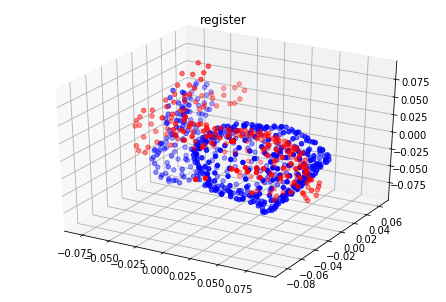

In [72]:
fig = plt.figure()
ax = Axes3D(fig)
data_ = x_train[1].reshape(-1, 3)
np.savetxt("testing_data.txt", data_)
x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='r', marker='o')


data_ = whole_pcd.reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('register')

In [82]:
whole_pcd = whole_pcd.reshape(-1, 3)

In [89]:
partial_pcd =  x_train[1].reshape(-1, 3)

In [90]:
np.savetxt(f'{save_path}\\train_data\{load_fname.stem}_whole_{whole_pcd.shape[0]}.txt', np.array(whole_pcd))

In [93]:
np.savetxt(f'{save_path}\\train_data\{load_fname.stem}_partial_{partial_pcd.shape[0]}.txt', np.array(partial_pcd))

In [104]:
def rm2Quaternion(rm):
    qw = np.sqrt(1 + rm[0, 0] + rm[1, 1] + rm[2, 2]) / 2
    qx = (rm[2, 1] - rm[1, 2]) / (4 * qw)
    qy = (rm[0, 2] - rm[2, 0]) / (4 * qw)
    qz = (rm[1, 0] - rm[0, 1]) / (4 * qw)

    return np.array([qw, qx, qy, qz])

In [95]:
rm = np.array([[0.9028779, -0.0880310, -0.416341],
               [0.0681816, 0.9957331, -0.0621720],
               [0.4223207, 0.0276521, 0.9060233]])

In [97]:
rm.shape

(3, 3)

In [105]:
q = rm2Quaternion(rm)

In [106]:
print(q)

[ 0.975274  0.023025 -0.214981  0.040043]


In [113]:
rotated_pcd = np.zeros(partial_pcd.shape)


In [114]:
for n in range(partial_pcd.shape[0]):
    rotated_pcd[n] = rotate_with_q(partial_pcd[n], q)

In [115]:
rotated_pcd.shape

(1728, 3)

Text(0.5, 0.92, 'register')

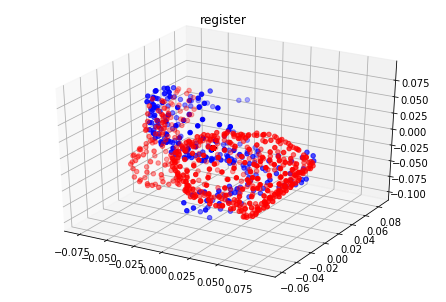

In [117]:
fig = plt.figure()
ax = Axes3D(fig)
data_ = whole_pcd.reshape(-1, 3)
np.savetxt("testing_data.txt", data_)
x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='r', marker='o')


data_ = rotated_pcd.reshape(-1, 3)

x = data_[:, 0]
y = data_[:, 1]
z = data_[:, 2]

ax.scatter(x, y, z, c='b', marker='o')
ax.set_title('register')